# Apple Identification - Image Recognition Project

![apples](./data/Images/apples_red_green.jpeg/)

## Overview / Business Problem

# ****

## Data Understanding

# ****

## Modeling

# ****

### Import Necessary Libraries

In [225]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import itertools
import random
import PIL
from PIL import Image
import io

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, \
GlobalAveragePooling2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras import models, layers 
from keras_preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import  Adam

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix

## Load the Files of Images

In [226]:
datagen = ImageDataGenerator()

In [227]:
no_aug_train_path =  './data/fruits-360_dataset/fruits-360_2/Training'
no_aug_test_path = './data/fruits-360_dataset/fruits-360_2/Test'
no_aug_val_path = './data/fruits-360_dataset/fruits-360_2/Validation'

aug_train_path =  './data/fruits-360_dataset/fruits-360/Training'
aug_test_path = './data/fruits-360_dataset/fruits-360/Test'
aug_val_path = './data/fruits-360_dataset/fruits-360/Validation'

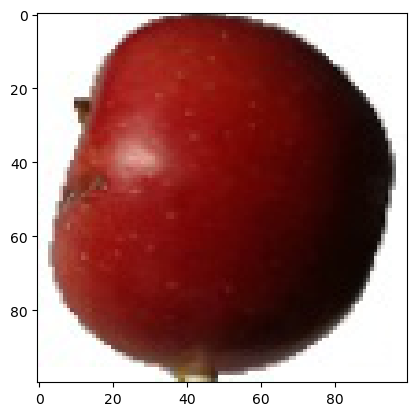

In [228]:
chosen_image = random.choice(os.listdir('./data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/'))
image_path = './data/fruits-360_dataset/fruits-360_2/Training/Apple Braeburn/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

## Modeling

### Baseline Model

In [229]:
baseline_train_datagen = ImageDataGenerator(rescale = 1./255)
baseline_test_datagen = ImageDataGenerator(rescale = 1./255)
baseline_val_datagen = ImageDataGenerator(rescale = 1./255)

In [230]:
baseline_image_size = (100, 100)
baseline_train_generator = baseline_train_datagen.flow_from_directory(
    no_aug_train_path,
    target_size = baseline_image_size,
    batch_size = 2563,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

baseline_test_generator = baseline_test_datagen.flow_from_directory(
    no_aug_test_path,
    target_size = baseline_image_size,
    batch_size = 954,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

baseline_val_generator = baseline_val_datagen.flow_from_directory(
    no_aug_val_path,
    target_size = baseline_image_size,
    batch_size = 285,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

Found 2563 images belonging to 6 classes.
Found 954 images belonging to 6 classes.
Found 285 images belonging to 6 classes.


In [231]:
train_class_names = list(baseline_train_generator.class_indices.keys())
train_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [232]:
# create the data sets
baseline_train_images, baseline_train_labels = next(baseline_train_generator)
baseline_test_images, baseline_test_labels = next(baseline_test_generator)
baseline_val_images, baseline_val_labels = next(baseline_val_generator)

In [233]:
baseline_train_img = baseline_train_images.reshape(baseline_train_images.shape[0], -1)
baseline_test_img = baseline_test_images.reshape(baseline_test_images.shape[0], -1)
baseline_val_img = baseline_val_images.reshape(baseline_val_images.shape[0], -1)

In [234]:
opt = Adam(learning_rate=0.0002)
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(6))

np.random.seed(3)
baseline_model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

baseline_model_histoire = baseline_model.fit(baseline_train_img,
                                       baseline_train_labels,
                                       epochs = 25,
                                       batch_size = 80,
                                       validation_data = (baseline_val_img, baseline_val_labels))

Epoch 1/25
 1/33 [..............................] - ETA: 8s - loss: 2.5484 - accuracy: 0.1375

2022-12-09 15:12:08.883292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 20ms/step - loss: 5.2188 - accuracy: 0.2794 - val_loss: 13.3469 - val_accuracy: 0.4211
Epoch 2/25
 8/33 [======>.......................] - ETA: 0s - loss: 10.3582 - accuracy: 0.4453

2022-12-09 15:12:09.569581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 9ms/step - loss: 8.7220 - accuracy: 0.4241 - val_loss: 8.1422 - val_accuracy: 0.4070
Epoch 3/25
33/33 [==============================] - 0s 8ms/step - loss: 7.9182 - accuracy: 0.3867 - val_loss: 8.0308 - val_accuracy: 0.3860
Epoch 4/25
33/33 [==============================] - 0s 8ms/step - loss: 13.3448 - accuracy: 0.3800 - val_loss: 13.4035 - val_accuracy: 0.3860
Epoch 5/25
33/33 [==============================] - 0s 8ms/step - loss: 13.4642 - accuracy: 0.3800 - val_loss: 13.4035 - val_accuracy: 0.3860
Epoch 6/25
33/33 [==============================] - 0s 8ms/step - loss: 13.4139 - accuracy: 0.3800 - val_loss: 13.4035 - val_accuracy: 0.3860
Epoch 7/25
33/33 [==============================] - 0s 8ms/step - loss: 13.4139 - accuracy: 0.3800 - val_loss: 13.4035 - val_accuracy: 0.3860
Epoch 8/25
33/33 [==============================] - 0s 8ms/step - loss: 13.4139 - accuracy: 0.3800 - val_loss: 13.4035 - val_accuracy: 0.3860
Epoch 9/25
33/33 [===

In [235]:
baseline_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 6)                 180006    
                                                                 
Total params: 180,006
Trainable params: 180,006
Non-trainable params: 0
_________________________________________________________________


In [236]:
baseline_model_results_train = baseline_model.evaluate(baseline_train_img, baseline_train_labels)
baseline_model_results_test = baseline_model.evaluate(baseline_test_img, baseline_test_labels)

30/30 [==============================] - 0s 6ms/step - loss: 13.4993 - accuracy: 0.3899


In [237]:
# baseline_model.save('./Supplement Notebooks/Saved Models/Baseline Model', save_format='tf')
baseline_model_saved = models.load_model('./Supplement Notebooks/Saved Models/Baseline Model')
baseline_model_saved.evaluate(baseline_train_img, baseline_train_labels)
baseline_model_saved.evaluate(baseline_test_img, baseline_test_labels)

16/81 [====>.........................] - ETA: 0s - loss: 10.3886 - accuracy: 0.3184

2022-12-09 15:12:16.662764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 6ms/step - loss: 9.9682 - accuracy: 0.3229


[9.96821403503418, 0.32285118103027344]

### Baseline Model Visualizations

#### Graphing Accuracy and Loss Metrics

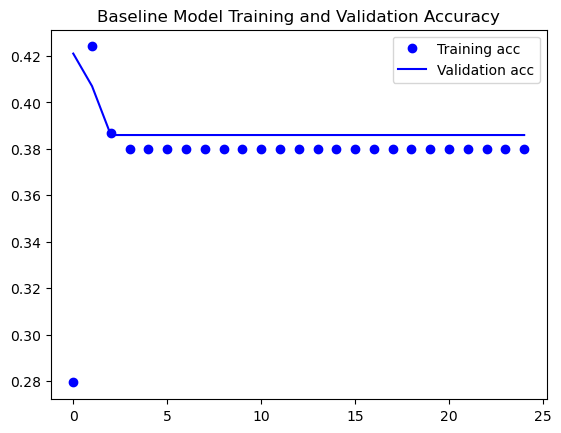

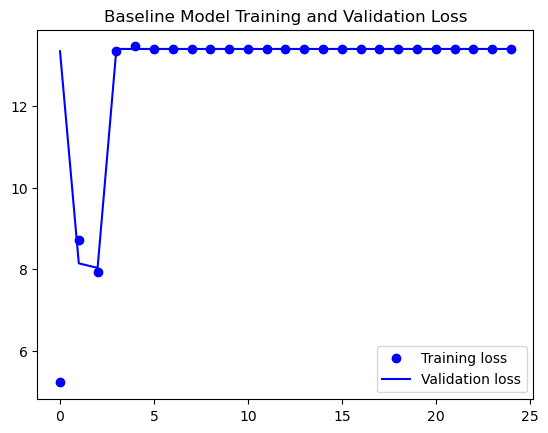

In [238]:
# Plot history
baseline_model_acc = baseline_model_histoire.history['accuracy']
baseline_model_val_acc = baseline_model_histoire.history['val_accuracy']
baseline_model_loss = baseline_model_histoire.history['loss']
baseline_model_val_loss = baseline_model_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_acc))

plt.plot(baseline_model_epochs, baseline_model_acc, 'bo', label = 'Training acc')
plt.plot(baseline_model_epochs, baseline_model_val_acc, 'b', label = 'Validation acc')
plt.title('Baseline Model Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.show();



### Second Model

#### Augment Images

# ****

In [239]:
aug_datagen = ImageDataGenerator(rescale = 1./255,
                                 shear_range = 0.2, 
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 rotation_range=10, 
                                 width_shift_range=0.1,  
                                 channel_shift_range=10.)

def augment_images(apple_name):
    names = [os.path.join(f'./data/fruits-360_dataset/fruits-360_2/Training/{apple_name}/'
                      , name) for name in os.listdir(f'./data/fruits-360_dataset/fruits-360_2/Training/{apple_name}/')]
    for f in names:
        if f.endswith('.jpg'):
            img = Image.open(f)
            x = img_to_array(img) 
            # Reshape the input image 
            x = x.reshape((1, ) + x.shape)  
            i = 0

            # generate 2 new augmented images 
            for batch in aug_datagen.flow(x, batch_size = 1, 
                              save_to_dir = f'./data/fruits-360_dataset/fruits-360/Training/{apple_name}',  
                              save_prefix = 'aug-image-', save_format ='jpg'):
                i += 1
                if i > 2: 
                    break

In [240]:
# DO NOT RUN
# augment_images('Apple Braeburn')
# augment_images('Apple Crimson Snow')
# augment_images('Apple Golden')
# augment_images('Apple Granny Smith')
# augment_images('Apple Pink Lady')
# augment_images('Apple Red Delicious')

## Modeling

### Second Model w/ Augmented Images

In [241]:
model_2_train_datagen = ImageDataGenerator(rescale = 1./255)
model_2_test_datagen = ImageDataGenerator(rescale = 1./255)
model_2_val_datagen = ImageDataGenerator(rescale = 1./255)

model_2_image_size = (100, 100)
model_2_train_generator = model_2_train_datagen.flow_from_directory(
    aug_train_path,
    target_size = model_2_image_size,
    batch_size = 7841,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_2_test_generator = model_2_test_datagen.flow_from_directory(
    aug_test_path,
    target_size = model_2_image_size,
    batch_size = 3017,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_2_val_generator = model_2_val_datagen.flow_from_directory(
    aug_val_path,
    target_size = model_2_image_size,
    batch_size = 1207,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

Found 7841 images belonging to 6 classes.
Found 3017 images belonging to 6 classes.
Found 1207 images belonging to 6 classes.


In [242]:
# create the data sets
model_2_train_images, model_2_train_labels = next(model_2_train_generator)
model_2_test_images, model_2_test_labels = next(model_2_test_generator)
model_2_val_images, model_2_val_labels = next(model_2_val_generator)

model_2_train_img = model_2_train_images.reshape(model_2_train_images.shape[0], -1)
model_2_test_img = model_2_test_images.reshape(model_2_test_images.shape[0], -1)
model_2_val_img = model_2_val_images.reshape(model_2_val_images.shape[0], -1)

In [243]:
model_2 = models.Sequential()
model_2.add(layers.Dense(6, activation = 'relu'))
model_2.add(layers.Dense(12, activation = 'relu'))
model_2.add(layers.Dense(48, activation = 'tanh'))
model_2.add(layers.Dense(6, activation = 'softmax'))

opt = Adam(learning_rate=0.0001)

np.random.seed(42)
model_2.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model_2_histoire = model_2.fit(model_2_train_img,
                               model_2_train_labels,
                               epochs = 50,
                               batch_size = 100,
                               validation_data = (model_2_val_img, model_2_val_labels))

Epoch 1/50
 1/79 [..............................] - ETA: 22s - loss: 1.8006 - accuracy: 0.1300

2022-12-09 15:12:22.237810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - ETA: 0s - loss: 1.5607 - accuracy: 0.3752

2022-12-09 15:12:23.772853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 21ms/step - loss: 1.5607 - accuracy: 0.3752 - val_loss: 1.5114 - val_accuracy: 0.4557
Epoch 2/50
79/79 [==============================] - 1s 16ms/step - loss: 1.3222 - accuracy: 0.5254 - val_loss: 1.3921 - val_accuracy: 0.5700
Epoch 3/50
79/79 [==============================] - 1s 15ms/step - loss: 1.1678 - accuracy: 0.6753 - val_loss: 1.3274 - val_accuracy: 0.6396
Epoch 4/50
79/79 [==============================] - 1s 16ms/step - loss: 1.0520 - accuracy: 0.7680 - val_loss: 1.2430 - val_accuracy: 0.6686
Epoch 5/50
79/79 [==============================] - 1s 15ms/step - loss: 0.9485 - accuracy: 0.7874 - val_loss: 1.1981 - val_accuracy: 0.6678
Epoch 6/50
79/79 [==============================] - 1s 15ms/step - loss: 0.8574 - accuracy: 0.8130 - val_loss: 1.1368 - val_accuracy: 0.6769
Epoch 7/50
79/79 [==============================] - 1s 15ms/step - loss: 0.7812 - accuracy: 0.8337 - val_loss: 1.0869 - val_accuracy: 0.7191
Epoch 8/50
79/79 [======

In [244]:
model_2.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 6)                 180006    
                                                                 
 dense_73 (Dense)            (None, 12)                84        
                                                                 
 dense_74 (Dense)            (None, 48)                624       
                                                                 
 dense_75 (Dense)            (None, 6)                 294       
                                                                 
Total params: 181,008
Trainable params: 181,008
Non-trainable params: 0
_________________________________________________________________


In [245]:
model_2_results_train = model_2.evaluate(model_2_train_img, model_2_train_labels)
model_2_results_test = model_2.evaluate(model_2_test_img, model_2_test_labels)

print(f'Model 2 Train Results: {model_2_results_train}')
print(f'Model 2 Test Results: {model_2_results_test}')

95/95 [==============================] - 1s 11ms/step - loss: 1.9266 - accuracy: 0.6543
Model 2 Train Results: [0.1690913885831833, 0.9464354515075684]
Model 2 Test Results: [1.9265921115875244, 0.6542923450469971]


In [269]:
# model_2.save('./Supplement Notebooks/Saved Models/Model 2', save_format='tf')
model_2_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 2')

model_2_saved.evaluate(model_2_train_img, model_2_train_labels)
model_2_saved.evaluate(model_2_test_img, model_2_test_labels)

  8/246 [..............................] - ETA: 3s - loss: 0.1718 - accuracy: 0.9297

2022-12-09 15:16:40.679010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 11ms/step - loss: 1.9266 - accuracy: 0.6543


[1.9265921115875244, 0.6542923450469971]

### Second Model w/ Augmented Images - Visualizations

#### Graphing Accuracy and Loss Metrics

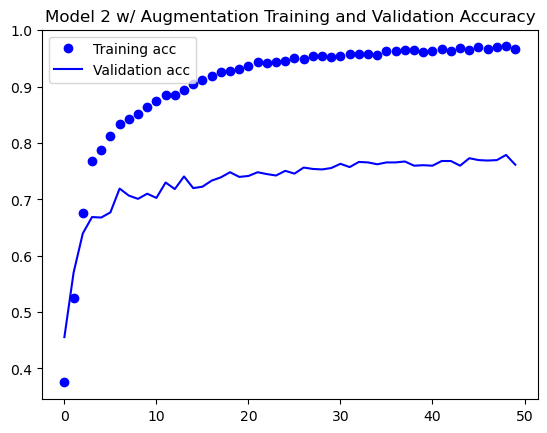

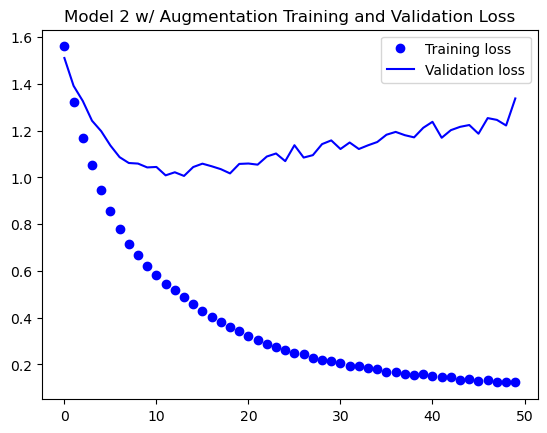

In [247]:
# Plot history
model_2_acc = model_2_histoire.history['accuracy']
model_2_val_acc = model_2_histoire.history['val_accuracy']
model_2_loss = model_2_histoire.history['loss']
model_2_val_loss = model_2_histoire.history['val_loss']
model_2_epochs = range(len(model_2_acc))

plt.plot(model_2_epochs, model_2_acc, 'bo', label = 'Training acc')
plt.plot(model_2_epochs, model_2_val_acc, 'b', label = 'Validation acc')
plt.title('Model 2 w/ Augmentation Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(model_2_epochs, model_2_loss, 'bo', label = 'Training loss')
plt.plot(model_2_epochs, model_2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 w/ Augmentation Training and Validation Loss')
plt.legend()
plt.show();

#### Confusion Matrix

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
2022-12-09 15:13:27.245413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


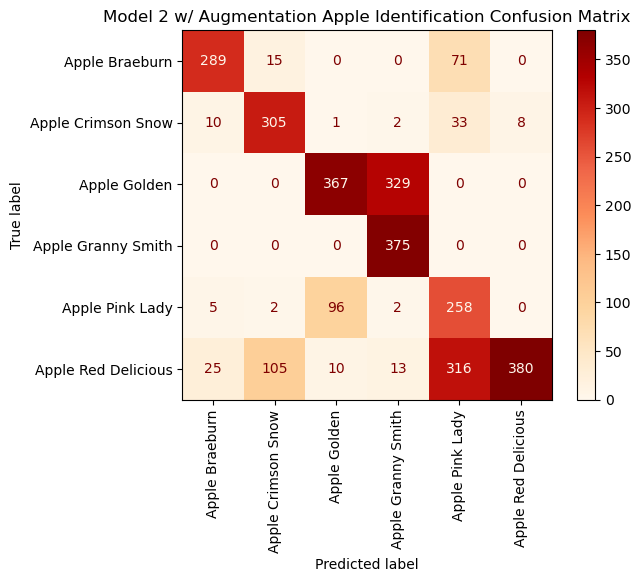

In [248]:
class_names = train_class_names
class estimator:
    _estimator_type = ''
    classes_= []
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob = self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)

        return y_pred
    
classifier = estimator(model_2, class_names)
plot_confusion_matrix(estimator = classifier, 
                      X = model_2_test_img, 
                      y_true = np.argmax(model_2_test_labels, axis = -1),
                      display_labels = class_names,
                      xticks_rotation = 'vertical',
                     cmap='OrRd');
plt.title('Model 2 w/ Augmentation Apple Identification Confusion Matrix')
plt.show()

### Second Model w/ No Augmented Images

# ****

In [249]:
no_aug_model_2_train_datagen = ImageDataGenerator(rescale = 1./255)
no_aug_model_2_test_datagen = ImageDataGenerator(rescale = 1./255)
no_aug_model_2_val_datagen = ImageDataGenerator(rescale = 1./255)

no_aug_model_2_train_generator = no_aug_model_2_train_datagen.flow_from_directory(
    no_aug_train_path,
    target_size = model_2_image_size,
    batch_size = 2563,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

no_aug_model_2_test_generator = no_aug_model_2_test_datagen.flow_from_directory(
    no_aug_test_path,
    target_size = model_2_image_size,
    batch_size = 954,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

no_aug_model_2_val_generator = no_aug_model_2_val_datagen.flow_from_directory(
    no_aug_val_path,
    target_size = model_2_image_size,
    batch_size = 285,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

# create the data sets
no_aug_model_2_train_images, no_aug_model_2_train_labels = next(no_aug_model_2_train_generator)
no_aug_model_2_test_images, no_aug_model_2_test_labels = next(no_aug_model_2_test_generator)
no_aug_model_2_val_images, no_aug_model_2_val_labels = next(no_aug_model_2_val_generator)

no_aug_model_2_train_img = no_aug_model_2_train_images.reshape(no_aug_model_2_train_images.shape[0], -1)
no_aug_model_2_test_img = no_aug_model_2_test_images.reshape(no_aug_model_2_test_images.shape[0], -1)
no_aug_model_2_val_img = no_aug_model_2_val_images.reshape(no_aug_model_2_val_images.shape[0], -1)

Found 2563 images belonging to 6 classes.
Found 954 images belonging to 6 classes.
Found 285 images belonging to 6 classes.


In [250]:
no_aug_model_2 = models.Sequential()
no_aug_model_2.add(layers.Dense(6, activation = 'relu'))
no_aug_model_2.add(layers.Dense(12, activation = 'relu'))
no_aug_model_2.add(layers.Dense(48, activation = 'tanh'))
no_aug_model_2.add(layers.Dense(6, activation = 'softmax'))

opt = Adam(learning_rate=0.0001)

np.random.seed(42)
no_aug_model_2.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

no_aug_model_2_histoire = no_aug_model_2.fit(no_aug_model_2_train_img,
                               no_aug_model_2_train_labels,
                               epochs = 50,
                               batch_size = 100,
                               validation_data = (no_aug_model_2_val_img, no_aug_model_2_val_labels))

Epoch 1/50
 1/26 [>.............................] - ETA: 6s - loss: 1.7930 - accuracy: 0.1200

2022-12-09 15:13:29.572243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 1s 26ms/step - loss: 1.6320 - accuracy: 0.3059 - val_loss: 1.4811 - val_accuracy: 0.3860
Epoch 2/50
 1/26 [>.............................] - ETA: 0s - loss: 1.5327 - accuracy: 0.3800

2022-12-09 15:13:30.238546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 0s 16ms/step - loss: 1.4382 - accuracy: 0.4389 - val_loss: 1.3498 - val_accuracy: 0.6211
Epoch 3/50
26/26 [==============================] - 0s 16ms/step - loss: 1.3205 - accuracy: 0.5287 - val_loss: 1.2393 - val_accuracy: 0.6386
Epoch 4/50
26/26 [==============================] - 0s 15ms/step - loss: 1.2247 - accuracy: 0.5743 - val_loss: 1.1652 - val_accuracy: 0.6632
Epoch 5/50
26/26 [==============================] - 0s 17ms/step - loss: 1.1488 - accuracy: 0.6059 - val_loss: 1.0950 - val_accuracy: 0.6667
Epoch 6/50
26/26 [==============================] - 0s 15ms/step - loss: 1.0826 - accuracy: 0.6375 - val_loss: 1.0320 - val_accuracy: 0.7018
Epoch 7/50
26/26 [==============================] - 0s 15ms/step - loss: 1.0258 - accuracy: 0.6886 - val_loss: 0.9783 - val_accuracy: 0.7439
Epoch 8/50
26/26 [==============================] - 0s 15ms/step - loss: 0.9711 - accuracy: 0.7257 - val_loss: 0.9264 - val_accuracy: 0.7684
Epoch 9/50
26/26 [======

In [251]:
no_aug_model_2.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 6)                 180006    
                                                                 
 dense_77 (Dense)            (None, 12)                84        
                                                                 
 dense_78 (Dense)            (None, 48)                624       
                                                                 
 dense_79 (Dense)            (None, 6)                 294       
                                                                 
Total params: 181,008
Trainable params: 181,008
Non-trainable params: 0
_________________________________________________________________


In [252]:
no_aug_model_2_results_train = no_aug_model_2.evaluate(no_aug_model_2_train_img, no_aug_model_2_train_labels)
no_aug_model_2_results_test = no_aug_model_2.evaluate(no_aug_model_2_test_img, no_aug_model_2_test_labels)

print(f'Model 2 w/out Augmentation Train Results: {no_aug_model_2_results_train}')
print(f'Model 2 w/out Augmentation Test Results: {no_aug_model_2_results_test}')

30/30 [==============================] - 0s 12ms/step - loss: 0.1988 - accuracy: 0.9686
Model 2 w/out Augmentation Train Results: [0.11424767225980759, 1.0]
Model 2 w/out Augmentation Test Results: [0.19880279898643494, 0.9685535430908203]


In [253]:
# no_aug_model_2.save('./Supplement Notebooks/Saved Models/Model 2 - No Data Aug', save_format='tf')
no_aug_model_2_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 2 - No Data Aug')
no_aug_model_2_saved.evaluate(no_aug_model_2_train_img, no_aug_model_2_train_labels)
no_aug_model_2_saved.evaluate(no_aug_model_2_test_img, no_aug_model_2_test_labels)

 9/81 [==>...........................] - ETA: 1s - loss: 0.1552 - accuracy: 1.0000

2022-12-09 15:13:50.907333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 12ms/step - loss: 0.2360 - accuracy: 0.9570


[0.2359982430934906, 0.9570231437683105]

### Third Model - w/ Augmented Images

# ****

In [254]:
model_3_train_datagen = ImageDataGenerator(rescale = 1./255,
                                          fill_mode = 'nearest')
model_3_test_datagen = ImageDataGenerator(rescale = 1./255)
model_3_val_datagen = ImageDataGenerator(rescale = 1./255)

model_3_image_size = (100, 100)
model_3_train_generator = model_3_train_datagen.flow_from_directory(
    aug_train_path,
    target_size = model_3_image_size,
    batch_size = 7841,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_3_test_generator = model_3_test_datagen.flow_from_directory(
    aug_test_path,
    target_size = model_3_image_size,
    batch_size = 3017,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)

model_3_val_generator = model_3_val_datagen.flow_from_directory(
    aug_val_path,
    target_size = model_3_image_size,
    batch_size = 1207,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 42)


# create the data sets
model_3_train_images, model_3_train_labels = next(model_3_train_generator)
model_3_test_images, model_3_test_labels = next(model_3_test_generator)
model_3_val_images, model_3_val_labels = next(model_3_val_generator)

Found 7841 images belonging to 6 classes.
Found 3017 images belonging to 6 classes.
Found 1207 images belonging to 6 classes.


In [255]:
#Instantiate a Regularizer
reg = l2(3e-3)

model_3 = models.Sequential()
model_3.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
model_3.add(layers.MaxPooling2D((2,2), padding = 'same'))
model_3.add(layers.Dropout(0.2))
# model_3.add(layers.Conv2D(36, (3,3), activation='relu')) # 2 hidden layers
# model_3.add(layers.Dropout(0.2))
# model_3.add(layers.MaxPooling2D((2,2), padding = 'same'))
# model_3.add(layers.Dropout(0.2))
# model_3.add(BatchNormalization())
model_3.add(layers.Flatten())
# model_3.add(layers.Dense(24, activation = 'relu', kernel_regularizer = reg))
# model_3.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
model_3.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
model_3.add(layers.Dense(6, activation='softmax', kernel_regularizer = reg))

opt = Adam(learning_rate=0.0002)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 1e-8, patience = 10)


np.random.seed(42)
model_3.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model_3_histoire = model_3.fit(model_3_train_images,
                                       model_3_train_labels,
                                       callbacks = [es],
                                       epochs = 70,
                                       batch_size = 120,
                                       validation_data = (model_3_val_images, model_3_val_labels))

Epoch 1/70


2022-12-09 15:13:56.452731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - ETA: 0s - loss: 1.4136 - accuracy: 0.5524

2022-12-09 15:13:59.452153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 3s 47ms/step - loss: 1.4136 - accuracy: 0.5524 - val_loss: 1.2601 - val_accuracy: 0.5758
Epoch 2/70
66/66 [==============================] - 3s 38ms/step - loss: 0.7163 - accuracy: 0.8433 - val_loss: 0.9532 - val_accuracy: 0.7589
Epoch 3/70
66/66 [==============================] - 3s 38ms/step - loss: 0.4976 - accuracy: 0.9269 - val_loss: 0.9109 - val_accuracy: 0.7904
Epoch 4/70
66/66 [==============================] - 2s 38ms/step - loss: 0.4063 - accuracy: 0.9489 - val_loss: 0.8276 - val_accuracy: 0.8161
Epoch 5/70
66/66 [==============================] - 2s 38ms/step - loss: 0.3467 - accuracy: 0.9621 - val_loss: 0.8638 - val_accuracy: 0.8119
Epoch 6/70
66/66 [==============================] - 3s 38ms/step - loss: 0.3092 - accuracy: 0.9686 - val_loss: 0.7725 - val_accuracy: 0.8318
Epoch 7/70
66/66 [==============================] - 2s 38ms/step - loss: 0.2857 - accuracy: 0.9722 - val_loss: 0.8811 - val_accuracy: 0.8194
Epoch 8/70
66/66 [======

In [256]:
model_3.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 18)        504       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 18)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 49, 49, 18)        0         
                                                                 
 flatten_8 (Flatten)         (None, 43218)             0         
                                                                 
 dense_80 (Dense)            (None, 48)                2074512   
                                                                 
 dense_81 (Dense)            (None, 6)                 294       
                                                     

In [257]:
model_3_results_train = model_3.evaluate(model_3_train_images, model_3_train_labels)
model_3_results_test = model_3.evaluate(model_3_test_images, model_3_test_labels)

print(f'Model 3 w/ Augmentation Train Results: {model_3_results_train}')
print(f'Model 3 w/ Augmentation Test Results: {model_3_results_test}')

95/95 [==============================] - 1s 13ms/step - loss: 1.1988 - accuracy: 0.7769
Model 3 w/ Augmentation Train Results: [0.16321857273578644, 0.9877567291259766]
Model 3 w/ Augmentation Test Results: [1.1988369226455688, 0.7769306898117065]


In [258]:
#model_3.save('./Supplement Notebooks/Saved Models/Model 3', save_format='tf')
model_3_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 3')
model_3_saved.evaluate(model_3_train_images, model_3_train_labels)
model_3_saved.evaluate(model_3_test_images, model_3_test_labels)

  3/246 [..............................] - ETA: 6s - loss: 0.2056 - accuracy: 0.9792 

2022-12-09 15:14:43.241379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 13ms/step - loss: 1.6850 - accuracy: 0.8041


[1.6850379705429077, 0.804110050201416]

### Third Model w/ Augmented Images - Visualizations

#### Graphing Accuracy and Loss Metrics

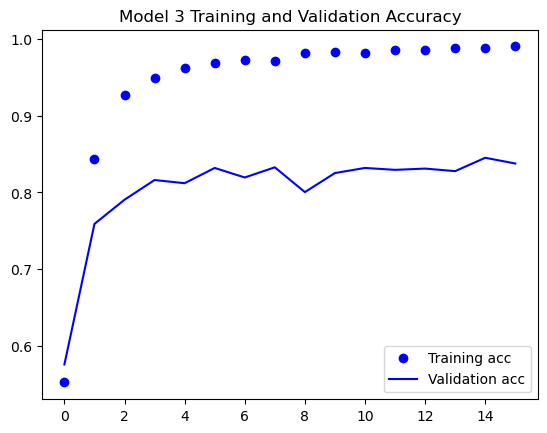

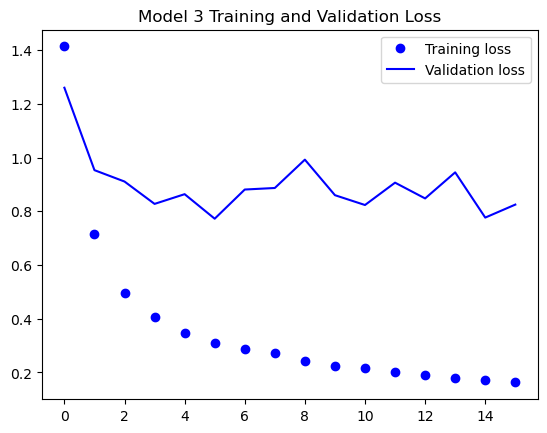

In [259]:
# Plot history
model_3_acc = model_3_histoire.history['accuracy']
model_3_val_acc = model_3_histoire.history['val_accuracy']
model_3_loss = model_3_histoire.history['loss']
model_3_val_loss = model_3_histoire.history['val_loss']
model_3_epochs = range(len(model_3_acc))

plt.plot(model_3_epochs, model_3_acc, 'bo', label = 'Training acc')
plt.plot(model_3_epochs, model_3_val_acc, 'b', label = 'Validation acc')
plt.title('Model 3 Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(model_3_epochs, model_3_loss, 'bo', label = 'Training loss')
plt.plot(model_3_epochs, model_3_val_loss, 'b', label = 'Validation loss')
plt.title('Model 3 Training and Validation Loss')
plt.legend()
plt.show();



#### Confusion Matrix

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
2022-12-09 15:14:48.245253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


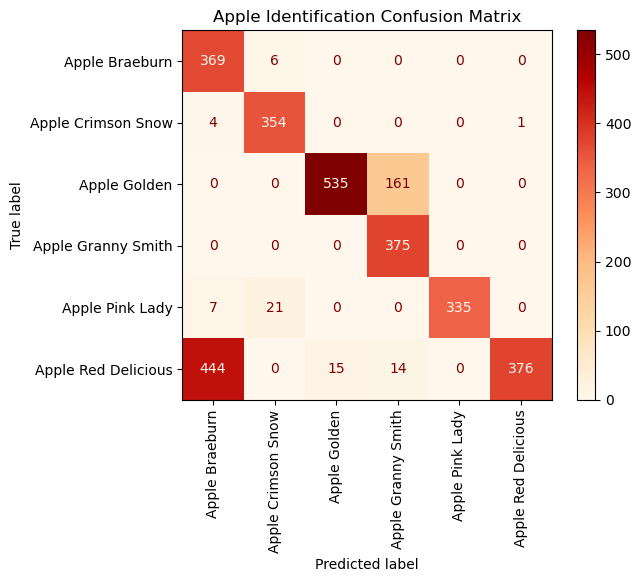

In [260]:
classifier = estimator(model_3, class_names)
plot_confusion_matrix(estimator = classifier, 
                      X = model_3_test_images, 
                      y_true = np.argmax(model_3_test_labels, axis = -1),
                      display_labels = class_names,
                      xticks_rotation = 'vertical',
                     cmap='OrRd');
plt.title('Apple Identification Confusion Matrix')
plt.show()

### Third Model - w/ No Augmented Images

# ****

In [261]:
no_aug_model_3_train_datagen = ImageDataGenerator(rescale = 1./255,
                                          fill_mode = 'nearest')
no_aug_model_3_test_datagen = ImageDataGenerator(rescale = 1./255)
no_aug_model_3_val_datagen = ImageDataGenerator(rescale = 1./255)

no_aug_model_3_train_generator = no_aug_model_3_train_datagen.flow_from_directory(no_aug_train_path,
                                                                                  target_size = model_3_image_size,
                                                                                  batch_size = 7841,
                                                                                  color_mode = 'rgb',
                                                                                  class_mode = 'categorical',
                                                                                  seed = 42)

no_aug_model_3_test_generator = no_aug_model_3_test_datagen.flow_from_directory(no_aug_test_path,
                                                                                target_size = model_3_image_size,
                                                                                batch_size = 3017,
                                                                                color_mode = 'rgb',
                                                                                class_mode = 'categorical',
                                                                                seed = 42)

no_aug_model_3_val_generator = no_aug_model_3_val_datagen.flow_from_directory(no_aug_val_path,
                                                                              target_size = model_3_image_size,
                                                                              batch_size = 1207,
                                                                              color_mode = 'rgb',
                                                                              class_mode = 'categorical',
                                                                              seed = 42)

# create the data sets
no_aug_model_3_train_images, no_aug_model_3_train_labels = next(no_aug_model_3_train_generator)
no_aug_model_3_test_images, no_aug_model_3_test_labels = next(no_aug_model_3_test_generator)
no_aug_model_3_val_images, no_aug_model_3_val_labels = next(no_aug_model_3_val_generator)

Found 2563 images belonging to 6 classes.
Found 954 images belonging to 6 classes.
Found 285 images belonging to 6 classes.


In [262]:
#Instantiate a Regularizer
reg = l2(3e-3)

no_aug_model_3 = models.Sequential()
no_aug_model_3.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
no_aug_model_3.add(layers.MaxPooling2D((2,2), padding = 'same'))
no_aug_model_3.add(layers.Dropout(0.2))
# model_3.add(layers.Conv2D(36, (3,3), activation='relu')) # 2 hidden layers
# model_3.add(layers.Dropout(0.2))
# model_3.add(layers.MaxPooling2D((2,2), padding = 'same'))
# model_3.add(layers.Dropout(0.2))
# model_3.add(BatchNormalization())
no_aug_model_3.add(layers.Flatten())
# model_3.add(layers.Dense(24, activation = 'relu', kernel_regularizer = reg))
# model_3.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
no_aug_model_3.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
no_aug_model_3.add(layers.Dense(6, activation='softmax', kernel_regularizer = reg))

opt = Adam(learning_rate=0.0002)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 1e-8, patience = 10)
np.random.seed(42)

no_aug_model_3.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

no_aug_model_3_histoire = no_aug_model_3.fit(no_aug_model_3_train_images,
                                       no_aug_model_3_train_labels,
                                       callbacks = [es],
                                       epochs = 70,
                                       batch_size = 120,
                                       validation_data = (no_aug_model_3_val_images, no_aug_model_3_val_labels))

Epoch 1/70


2022-12-09 15:14:50.865297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 2s 55ms/step - loss: 1.5488 - accuracy: 0.5622 - val_loss: 0.8495 - val_accuracy: 0.9263
Epoch 2/70


2022-12-09 15:14:52.117647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 39ms/step - loss: 0.6712 - accuracy: 0.9227 - val_loss: 0.4608 - val_accuracy: 0.9930
Epoch 3/70
22/22 [==============================] - 1s 38ms/step - loss: 0.3953 - accuracy: 0.9742 - val_loss: 0.3251 - val_accuracy: 1.0000
Epoch 4/70
22/22 [==============================] - 1s 39ms/step - loss: 0.2904 - accuracy: 0.9930 - val_loss: 0.2585 - val_accuracy: 1.0000
Epoch 5/70
22/22 [==============================] - 1s 38ms/step - loss: 0.2474 - accuracy: 0.9949 - val_loss: 0.2287 - val_accuracy: 1.0000
Epoch 6/70
22/22 [==============================] - 1s 38ms/step - loss: 0.2221 - accuracy: 0.9969 - val_loss: 0.2187 - val_accuracy: 1.0000
Epoch 7/70
22/22 [==============================] - 1s 38ms/step - loss: 0.2034 - accuracy: 0.9988 - val_loss: 0.1987 - val_accuracy: 1.0000
Epoch 8/70
22/22 [==============================] - 1s 37ms/step - loss: 0.1896 - accuracy: 0.9984 - val_loss: 0.1848 - val_accuracy: 1.0000
Epoch 9/70
22/22 [======

Epoch 60/70
22/22 [==============================] - 1s 38ms/step - loss: 0.0399 - accuracy: 1.0000 - val_loss: 0.0404 - val_accuracy: 1.0000
Epoch 61/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0389 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 1.0000
Epoch 62/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0382 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 1.0000
Epoch 63/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 1.0000
Epoch 64/70
22/22 [==============================] - 1s 38ms/step - loss: 0.0439 - accuracy: 0.9996 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 65/70
22/22 [==============================] - 1s 38ms/step - loss: 0.0467 - accuracy: 0.9992 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 66/70
22/22 [==============================] - 1s 37ms/step - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 

In [263]:
no_aug_model_3.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 18)        504       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 49, 49, 18)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 49, 49, 18)        0         
                                                                 
 flatten_9 (Flatten)         (None, 43218)             0         
                                                                 
 dense_82 (Dense)            (None, 48)                2074512   
                                                                 
 dense_83 (Dense)            (None, 6)                 294       
                                                     

In [264]:
no_aug_model_3_results_train = no_aug_model_3.evaluate(no_aug_model_3_train_images, no_aug_model_3_train_labels)
no_aug_model_3_results_test = no_aug_model_3.evaluate(no_aug_model_3_test_images, no_aug_model_3_test_labels)

print(f'Model 3 w/ No Augmentation Train Results: {no_aug_model_3_results_train}')
print(f'Model 3 w/ No Augmentation Test Results: {no_aug_model_3_results_test}')

30/30 [==============================] - 0s 14ms/step - loss: 0.1372 - accuracy: 0.9623
Model 3 w/ No Augmentation Train Results: [0.03375036641955376, 1.0]
Model 3 w/ No Augmentation Test Results: [0.13720346987247467, 0.9622642397880554]


In [265]:
# no_aug_model_3.save('./Supplement Notebooks/Saved Models/Model 3 - No Data Aug', save_format='tf')
no_aug_model_3_saved = models.load_model('./Supplement Notebooks/Saved Models/Model 3 - No Data Aug')
no_aug_model_3_saved.evaluate(no_aug_model_3_train_images, no_aug_model_3_train_labels)
no_aug_model_3_saved.evaluate(no_aug_model_3_test_images, no_aug_model_3_test_labels)

 3/81 [>.............................] - ETA: 2s - loss: 0.0350 - accuracy: 1.0000 

2022-12-09 15:15:51.336701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 14ms/step - loss: 0.1211 - accuracy: 0.9623


[0.121090367436409, 0.9622642397880554]

### Final Results

# ****

## Recommendation:

# ****

### Next Steps:

# ****